In [2]:
pip3 install --upgrade pip

  Using cached pip-22.0.4-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 21.3.1
    Uninstalling pip-21.3.1:
      Successfully uninstalled pip-21.3.1
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade tensorflow

Note: you may need to restart the kernel to use updated packages.


# Dogs vs Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [4]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg16

print(tf.__version__)
print(tf.executing_eagerly())

2.8.0
True


## Функции загрузки данных

In [5]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob('data_full/train_sample/*.jpg')
test_files = glob('data_full/test_sample/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  # предобработка для VGG16

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

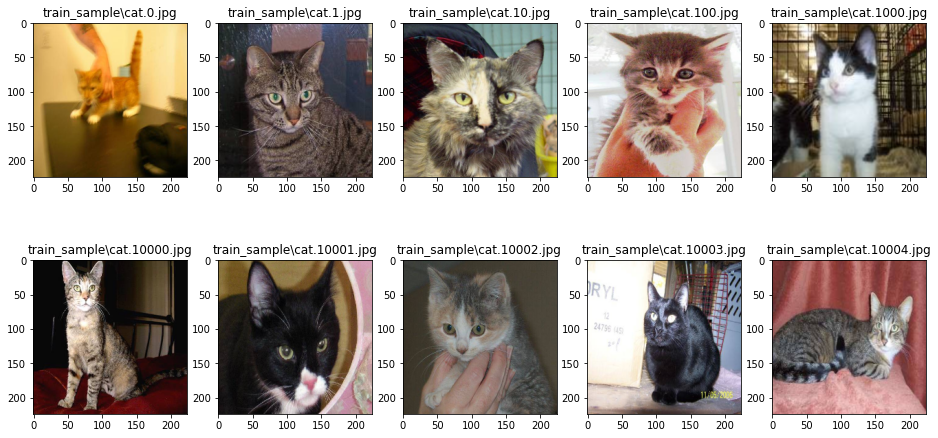

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

## Загружаем предобученную модель

In [7]:
# base_model - объект класса keras.models.Model (Functional Model)
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

In [9]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Добавляем полносвязный слой

In [8]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-5].output
x = tf.keras.layers.Flatten()(x)
# TODO: add normalization
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.BatchNormalization()(x) # пакетная нормализация
x = tf.keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid',  # функция активации  
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

## Выводим архитектуру модели

In [10]:
model.summary()

Model: "dogs_vs_cats"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)      

## Компилируем модель и запускаем обучение

In [11]:
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss)
              metrics=['accuracy'])

In [12]:
val_samples = 5  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=10,  # число вызовов генератора за эпоху
          epochs=100,  # число эпох обучения
          validation_data=validation_data)

Epoch 1/100
10/10 [==============================] - 128s 13s/step - loss: 0.4889 - accuracy: 0.7469 - val_loss: 0.4979 - val_accuracy: 0.8000
Epoch 2/100
10/10 [==============================] - 143s 14s/step - loss: 0.3535 - accuracy: 0.8375 - val_loss: 0.2872 - val_accuracy: 0.8000
Epoch 3/100
10/10 [==============================] - 162s 16s/step - loss: 0.3099 - accuracy: 0.8594 - val_loss: 0.3908 - val_accuracy: 0.8000
Epoch 4/100
10/10 [==============================] - 130s 13s/step - loss: 0.2793 - accuracy: 0.8813 - val_loss: 0.2883 - val_accuracy: 0.8000
Epoch 5/100
10/10 [==============================] - 101s 10s/step - loss: 0.3260 - accuracy: 0.8687 - val_loss: 1.2167 - val_accuracy: 0.6000
Epoch 6/100
10/10 [==============================] - 114s 12s/step - loss: 0.2542 - accuracy: 0.8906 - val_loss: 0.3243 - val_accuracy: 0.8000
Epoch 7/100
10/10 [==============================] - 115s 12s/step - loss: 0.2661 - accuracy: 0.8969 - val_loss: 0.0765 - val_accuracy: 1.0000

10/10 [==============================] - 97s 10s/step - loss: 0.1011 - accuracy: 0.9656 - val_loss: 0.0095 - val_accuracy: 1.0000
Epoch 59/100
10/10 [==============================] - 101s 10s/step - loss: 0.1427 - accuracy: 0.9469 - val_loss: 0.0119 - val_accuracy: 1.0000
Epoch 60/100
10/10 [==============================] - 101s 10s/step - loss: 0.1636 - accuracy: 0.9344 - val_loss: 0.0076 - val_accuracy: 1.0000
Epoch 61/100
10/10 [==============================] - 106s 11s/step - loss: 0.1545 - accuracy: 0.9406 - val_loss: 0.0127 - val_accuracy: 1.0000
Epoch 62/100
10/10 [==============================] - 102s 10s/step - loss: 0.1416 - accuracy: 0.9438 - val_loss: 0.0047 - val_accuracy: 1.0000
Epoch 63/100
10/10 [==============================] - 101s 10s/step - loss: 0.1507 - accuracy: 0.9469 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 64/100
10/10 [==============================] - 103s 10s/step - loss: 0.1442 - accuracy: 0.9438 - val_loss: 0.0050 - val_accuracy: 1.0000
Epoch 

In [13]:
model.save('cats-dogs-vgg16_3.hdf5')

## Предсказания на проверочной выборке

In [14]:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

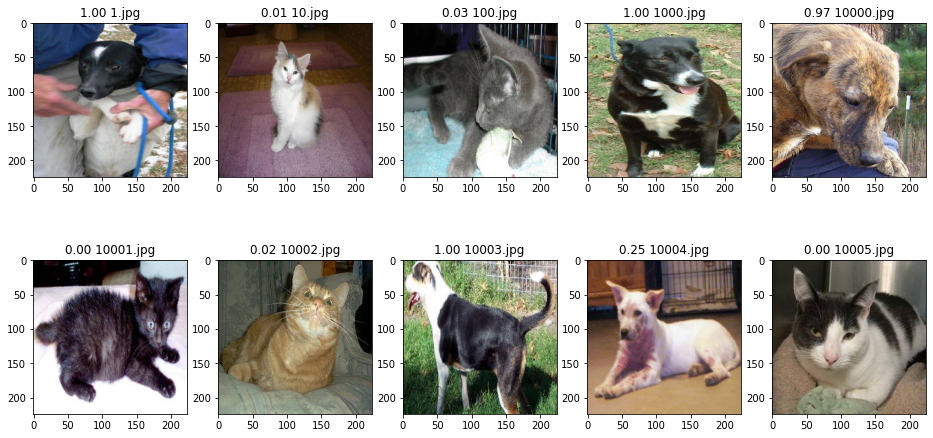

In [15]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

## Готовим данные для отправки

In [16]:
import re

with open('submit_3.csv', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))